In [1]:
from formulae import design_matrices

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from bambi.plots import plot_cap
from matplotlib.lines import Line2D

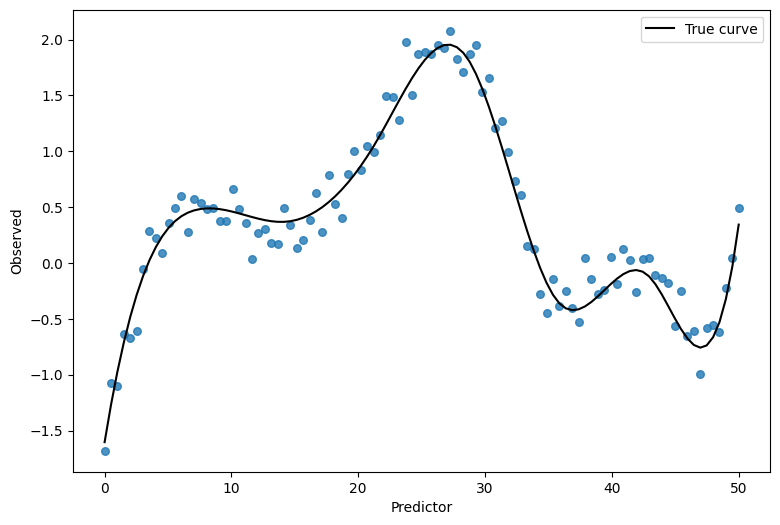

In [2]:
rng = np.random.default_rng(seed=1234)

N = 100
x = np.linspace(0, 50, N)
b = 0.1 * rng.normal(size=10)
sigma_t = 0.15

dm = design_matrices("0 + bs(x, df=10, intercept=True)", pd.DataFrame({"x": x}))
X = np.array(dm.common)
f = 10 * X @ b
y = f + sigma_t * rng.normal(size=N)
df = pd.DataFrame({"x": x, "y": y})

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(x, y, s=30, alpha=0.8)
ax.plot(x, f, color="black", label="True curve")
ax.set(xlabel="Predictor", ylabel="Observed")
ax.legend();

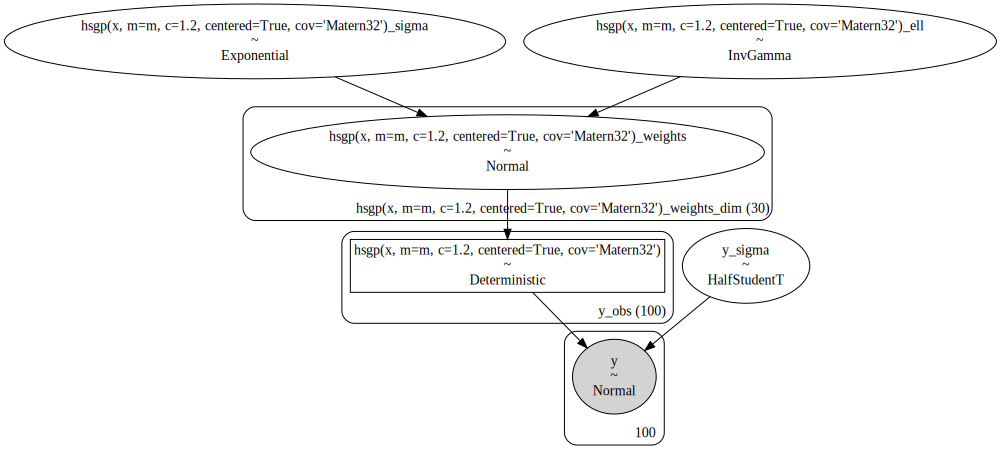

In [3]:
m = [30]
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=2),
    "ell": bmb.Prior("InverseGamma", mu=10, sigma=1),
}
priors = {"hsgp(x, m=m, c=1.2, centered=True, cov='Matern32')": prior_hsgp}
model = bmb.Model("y ~ 0 + hsgp(x, m=m, c=1.2, centered=True, cov='Matern32')", df, priors=priors)
model.build()
model.graph()

Names are quite long and hard to read... Use aliases!

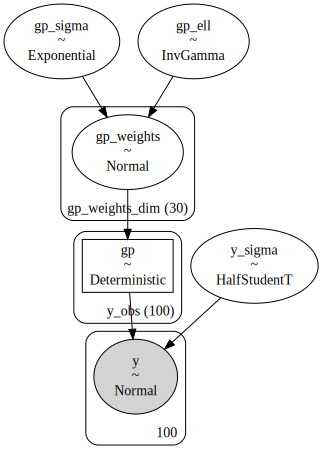

In [4]:
model.set_alias({"hsgp(x, m=m, c=1.2, centered=True, cov='Matern32')": "gp"})
model.build()
model.graph()

In [5]:
idata = model.fit(inference_method="nuts_numpyro")

/home/tomas/anaconda3/envs/bambi_hsgp/lib/python3.10/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:03.905458
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:07.199526
Transforming variables...
Transformation time =  0:00:00.258855


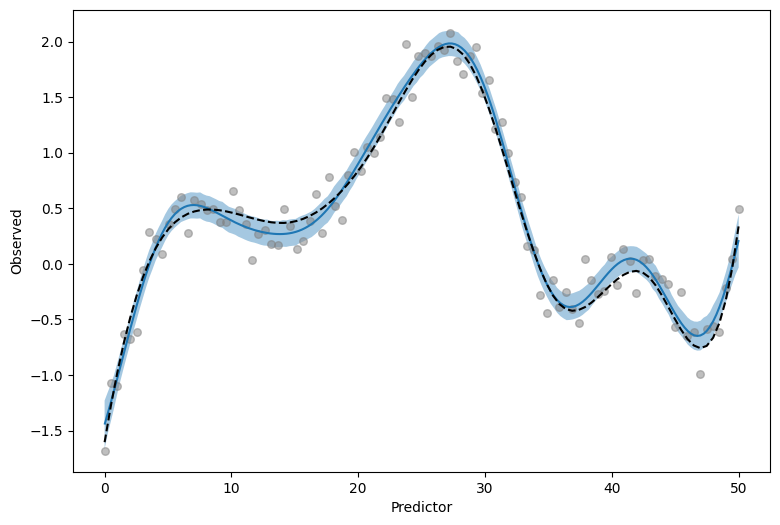

In [6]:
fig, ax = plt.subplots(figsize=(9, 6))
plot_cap(model, idata, "x", ax=ax)
ax.scatter(df["x"], df["y"], s=30, color="0.5", alpha=0.5)
ax.plot(x, f, color="black", ls="--")
ax.set(xlabel="Predictor", ylabel="Observed");

We can also take samples from the posterior predictive distribution...

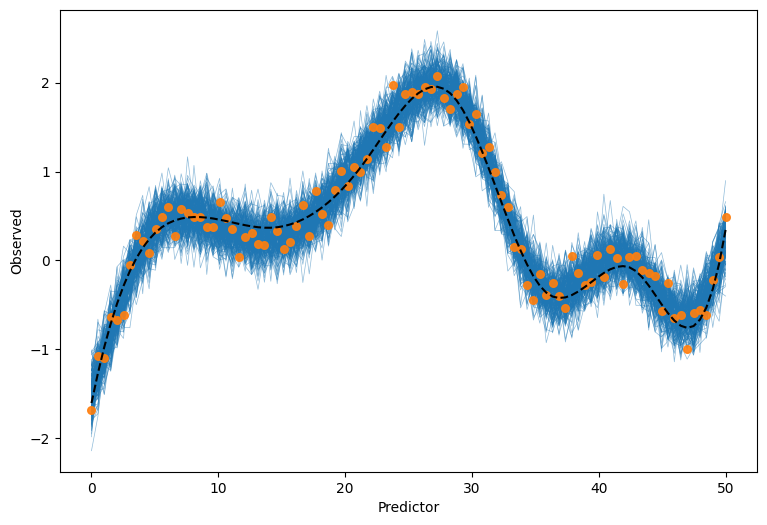

In [7]:
model.predict(idata, kind="pps")
pps = idata.posterior_predictive["y"].to_numpy().reshape(4000, 100)

fig, ax = plt.subplots(figsize=(9, 6))

for pps_draw in pps[::20, :]:
    ax.plot(df["x"], pps_draw, color="C0", lw=0.5, alpha=0.5, zorder=-3)

ax.scatter(df["x"], df["y"], s=30, color="C1", alpha=0.9)
ax.plot(x, f, color="black", ls="--")
ax.set(xlabel="Predictor", ylabel="Observed");

Why not using an out-of-sample dataset?

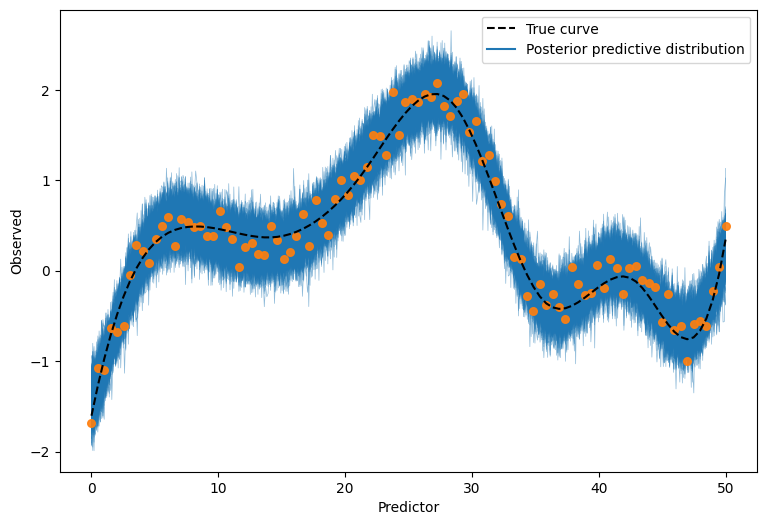

In [8]:
new_data = pd.DataFrame({"x": np.linspace(0, 50, num=500)})
model.predict(idata, kind="pps", data=new_data)
pps = idata.posterior_predictive["y"].to_numpy().reshape(4000, 500)

fig, ax = plt.subplots(figsize=(9, 6))

for pps_draw in pps[::20, :]:
    ax.plot(new_data["x"], pps_draw, color="C0", lw=0.5, alpha=0.5, zorder=-3)

ax.scatter(df["x"], df["y"], s=30, color="C1", alpha=0.9)
ax.plot(x, f, color="black", ls="--")
ax.set(xlabel="Predictor", ylabel="Observed");

handles = [Line2D([], [], color="black", ls="--"), Line2D([], [], color="C0")]
labels = ["True curve", "Posterior predictive distribution"]
ax.legend(handles, labels);

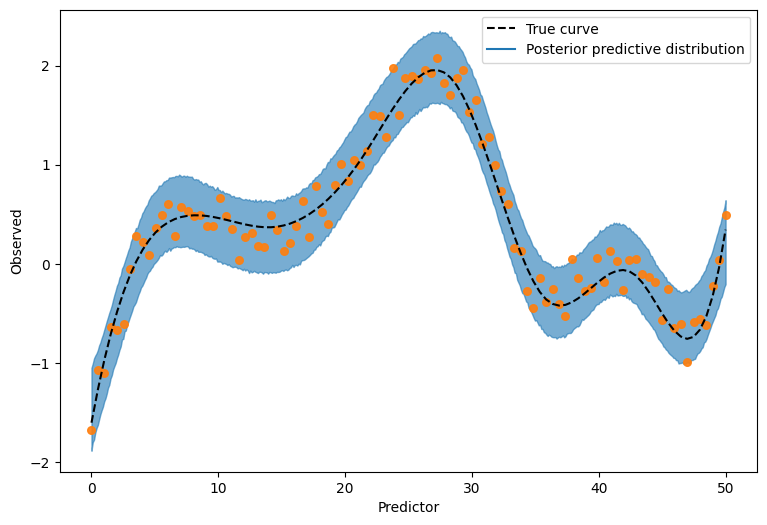

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))

qts = np.quantile(pps, q=(0.025, 0.975), axis=0)

ax.fill_between(new_data["x"], qts[0], qts[1], color="C0", alpha=0.6)
ax.scatter(df["x"], df["y"], s=30, color="C1", alpha=0.9)
ax.plot(x, f, color="black", ls="--")
ax.set(xlabel="Predictor", ylabel="Observed");

handles = [Line2D([], [], color="black", ls="--"), Line2D([], [], color="C0")]
labels = ["True curve", "Posterior predictive distribution"]
ax.legend(handles, labels);